**Before you start**: To run this notebook the `channel_videos.json` file and the `recommendation_bias.json` dataset must be present in the same directory as this notebook. The files can be collected by running `MineBias.py` script or by downloading old ones from https://kaggle.com/datasets/06a287ddf5f5c351434e95282c95fd11869d9d7a20b034ff586892d60c10418f.

### Load and test the dataset

In [2]:
# Load the dataset 
import json

#channel_videos
with open('channel_videos.json', 'r') as f:
    channel_videos = json.load(f)

#recommendation_bias
with open('recommendation_bias.json', 'r') as f:
    recommendation_bias = json.load(f)

print("Successfully loaded channel_videos and recommendation_bias datasets.")

Successfully loaded channel_videos and recommendation_bias datasets.


In [3]:
# Calculate key statistics

# calculate the number of channels
total_channels = len(channel_videos)

# calculate the number of videos 
total_videos = 0
for channel in channel_videos:
    total_videos += len(channel_videos[channel])

# calculate the number recommendations
total_recommendations = 0
for channel in recommendation_bias:
    for video in recommendation_bias[channel]:
        total_recommendations += len(recommendation_bias[channel][video])

print(f"The dataset contains {total_channels} channels which uploaded a total of {total_videos} videos with {total_recommendations} recommendations.")

The dataset contains 75 channels which uploaded a total of 84919 videos with 1591385 recommendations.


In [4]:
# Define some helper functions
from src.biasRepository import BiasRepository

bias_repo = BiasRepository()

def get_bias_color(bias):
    """
    Get the color associated with a bias for plotting.
    """
    bias_color_map = {
        'left': 'royalblue',
        'lean-left': 'lightblue',
        'center': 'lightgrey',
        'lean-right': 'indianred',
        'right': 'maroon'
    }
    color = bias_color_map.get(bias, 'black')
    if color == 'black':
        bias_rep = bias_repo.get_bias(bias)
        if bias_rep:
            color = bias_color_map.get(bias_rep, 'black')
    return color

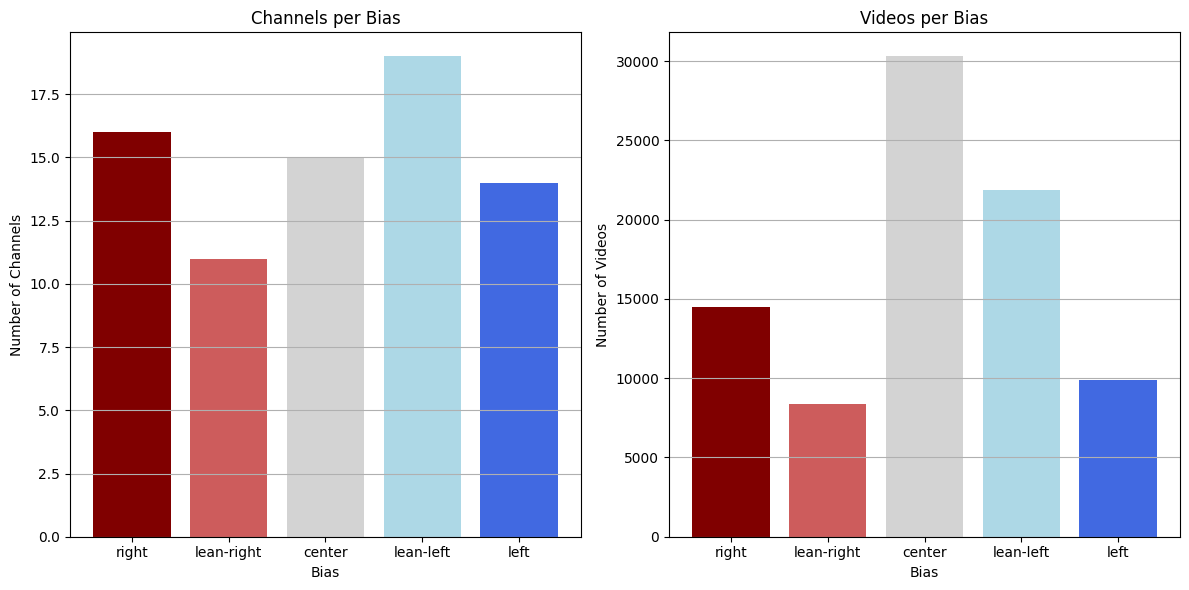

In [5]:
# Accumulate channels and videos by bias
import matplotlib.pyplot as plt

# how many channels per bias
channel_bias_counts = {}
for channel in channel_videos:
    bias = bias_repo.get_bias(channel)
    if bias not in channel_bias_counts:
        channel_bias_counts[bias] = 1
    else:
        channel_bias_counts[bias] += 1

# how many videos per bias
colors = ['maroon', 'indianred', 'lightgrey', 'lightblue', 'royalblue']
video_bias_counts = {}
for channel in channel_videos:
    bias = bias_repo.get_bias(channel)
    if bias not in video_bias_counts:
        video_bias_counts[bias] = len(channel_videos[channel])
    else:
        video_bias_counts[bias] += len(channel_videos[channel])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(channel_bias_counts.keys(), channel_bias_counts.values(), color=colors)
ax[0].set_title('Channels per Bias')
ax[0].set_xlabel('Bias')
ax[0].set_ylabel('Number of Channels')
ax[0].grid(axis='y')

ax[1].bar(video_bias_counts.keys(), video_bias_counts.values(), color=colors)
ax[1].set_title('Videos per Bias')
ax[1].set_xlabel('Bias')
ax[1].set_ylabel('Number of Videos')
ax[1].grid(axis='y')

plt.tight_layout()
plt.show()

The first insight from the dataset is the number of channels per bias group. Lean-left is the most common one and lean-right is the least common one. The US media landscape on YouTube seems to be slightly left leaning at lest from the number of channels. The total number of videos is slightly diffrent witch center being the most commong one instead of lean-left. That is mainly due to center channels like Forbes having a high upload frequency.

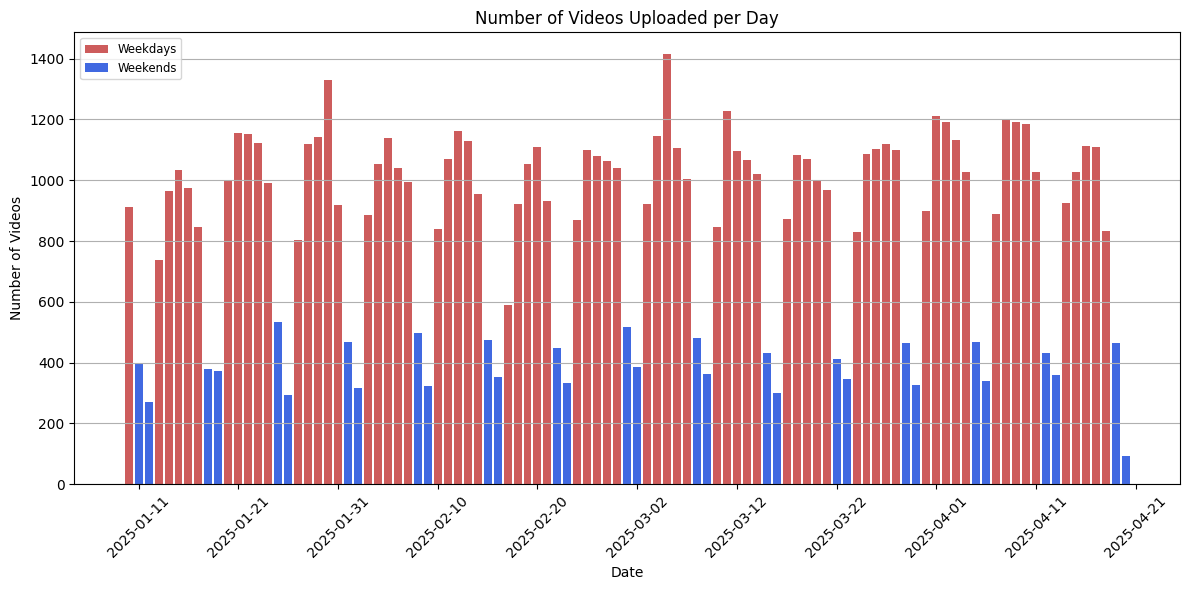

In [6]:
# plot the number of videos uploaded per day
import matplotlib.dates as mdates
import datetime
from matplotlib.patches import Patch
dates = {}

for channel in channel_videos:
    for video in channel_videos[channel]:
        date = video['snippet']['publishedAt'].split('T')[0]
        if date not in dates:
            dates[date] = 1
        else:
            dates[date] += 1

dates = {datetime.datetime.strptime(date, '%Y-%m-%d'): count for date, count in dates.items()}
dates = dict(sorted(dates.items()))
# highlight weekends
colors = ['indianred' if date.weekday() < 5 else 'royalblue' for date in dates.keys()]
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(dates.keys(), dates.values(), color=colors, width=0.8)
ax.set_title('Number of Videos Uploaded per Day')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Videos')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
legend = [{'label': 'Weekdays', 'color': 'indianred'}, {'label': 'Weekends', 'color': 'royalblue'}]
legend_elements = [Patch(facecolor=legend[0]['color'], label=legend[0]['label']),
                   Patch(facecolor=legend[1]['color'], label=legend[1]['label'])]
ax.legend(handles=legend_elements, loc='upper left', fontsize='small')


#plt.legend(['Weekdays', 'Weekends'], loc='upper left', fontsize='small')
plt.show()

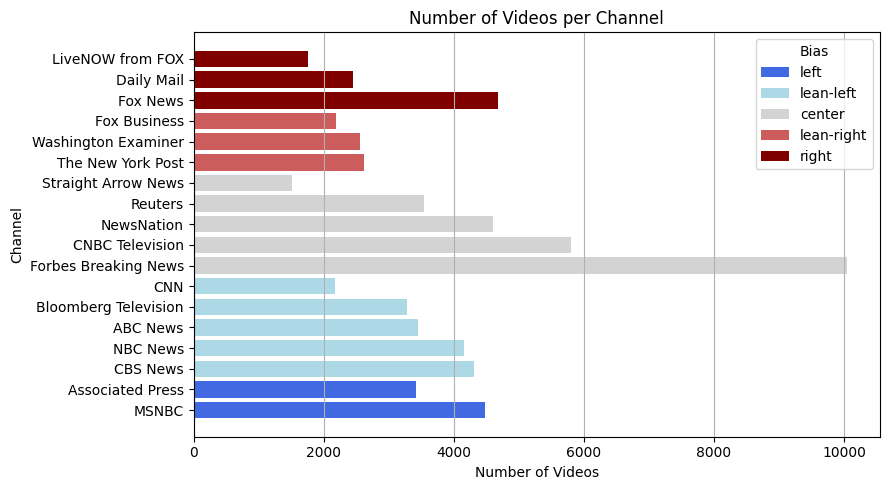

In [7]:
# Model the number of videos per channel
channels_grouped_by_bias = {'left': [], 'lean-left': [], 'center': [], 'lean-right': [], 'right': []}
for channel in channel_videos:
    num_videos = len(channel_videos[channel])
    if num_videos > 1500:
        bias = bias_repo.get_bias(channel)
        channels_grouped_by_bias[bias].append({
            'channel': bias_repo.get_outlet_name_by_id(channel),
            'num_videos': num_videos,
            'color': get_bias_color(bias)
        })

# Sort the channels by number of videos
for bias in channels_grouped_by_bias:
    channels_grouped_by_bias[bias].sort(key=lambda x: x['num_videos'], reverse=True)

# Plot the number of videos per channel
fig, ax = plt.subplots(figsize=(9, 5))
for bias in channels_grouped_by_bias:
    channels = channels_grouped_by_bias[bias]
    channel_names = [channel['channel'] for channel in channels]
    num_videos = [channel['num_videos'] for channel in channels]
    color = channels[0]['color']
    ax.barh(channel_names, num_videos, color=color, label=bias)

ax.set_title('Number of Videos per Channel')
ax.set_xlabel('Number of Videos')
ax.set_ylabel('Channel')
ax.legend(title='Bias')
ax.grid(axis='x')
plt.tight_layout()
plt.show()

From the figure can be observed that the high number of videos in the center group originates particulary from the high number of uploads made by Forbes, CNBC and NewsNation. The right bias is dominated by the Fox News Network while the left-leaning and left group is more diversified. Shown are only channels which uploaded more than 1500 videos during the 100 day time period.

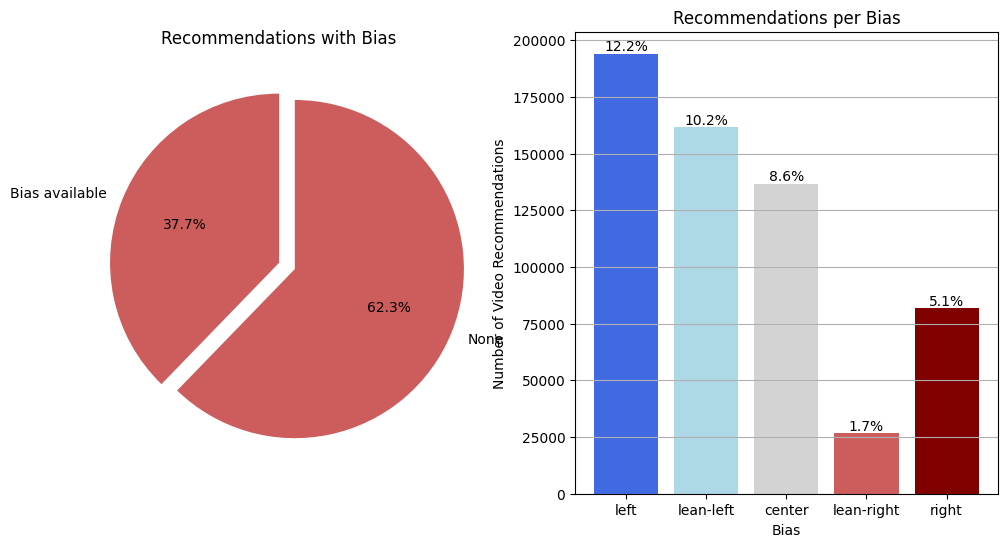

In [8]:
# Accumulate recommendations by bias
recommendation_bias_counts = {'left': 0, 'lean-left': 0, 'center': 0, 'lean-right': 0, 'right': 0}
recommendation_bias_percentages = {'left': 0, 'lean-left': 0, 'center': 0, 'lean-right': 0, 'right': 0}
colors = ['royalblue', 'lightblue', 'lightgrey', 'indianred', 'maroon']
none = 0
for channel in recommendation_bias:
    for video in recommendation_bias[channel]:
        for recommendation in recommendation_bias[channel][video]:
            bias = bias_repo.get_bias(recommendation['channel_id'])
            if bias is None:
                none += 1
            else:
                recommendation_bias_counts[bias] += 1
# Calculate the percentage of recommendations per bias
for bias in recommendation_bias_counts:
    if total_recommendations > 0:
        recommendation_bias_percentages[bias] = (recommendation_bias_counts[bias] / total_recommendations) * 100
    else:
        recommendation_bias_percentages[bias] = 0
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].pie([none, total_recommendations-none], labels=['None', 'Bias available'], colors=['indianred', 'indianred'], startangle=90, counterclock=False, autopct='%1.1f%%', explode=(0.1, 0))
ax[0].set_title('Recommendations with Bias')
ax[1].bar(recommendation_bias_counts.keys(), recommendation_bias_counts.values(), color=colors)
ax[1].set_title('Recommendations per Bias')
ax[1].set_xlabel('Bias')
ax[1].set_ylabel('Number of Video Recommendations')
ax[1].grid(axis='y')
#annotate the percentage of recommendations per bias over the bars
for i, v in enumerate(recommendation_bias_counts.values()):
   ax[1].text(i, v + 0.5, f"{recommendation_bias_percentages[list(recommendation_bias_counts.keys())[i]]:.1f}%", ha='center', va='bottom')
plt.show()

Around _37.7% of the video recommendations overlap with the channels in the dataset. Most recommendations were to _left_ channels while _right_ was the least common.

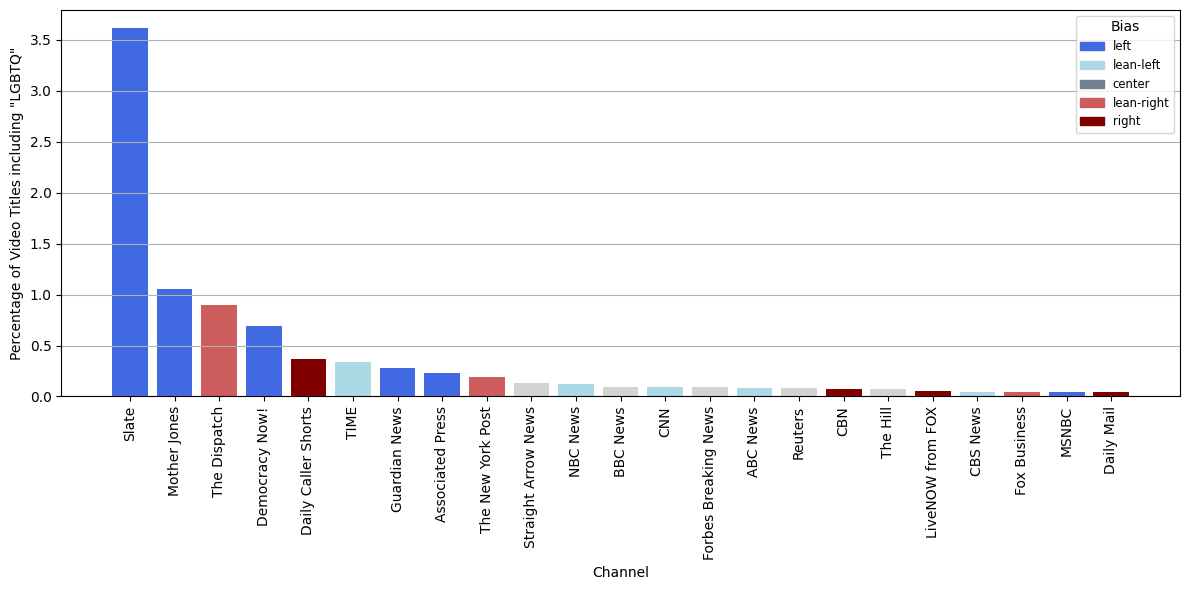

In [20]:
# count how often lgbtq is mentioned in the video titles for each channel
lgbtq_counts = {}
for channel in channel_videos:
    lgbtq_counts[channel] = 0
    for video in channel_videos[channel]:
        if "lgbtq" in video["snippet"]["title"].lower():
            lgbtq_counts[channel] += 1
    if len(channel_videos[channel]) > 0:
        # normalize the counts by the number of videos uploaded by the channel
        lgbtq_counts[channel] = lgbtq_counts[channel] / len(channel_videos[channel]) * 100

# sort the channels by number of lgbtq mentions
lgbtq_counts = dict(sorted(lgbtq_counts.items(), key=lambda x: x[1], reverse=True))
# filter out channels with no lgbtq mentions
lgbtq_counts = {channel: count for channel, count in lgbtq_counts.items() if count > 0}
# plot the number of lgbtq mentions per channel
fig, ax = plt.subplots(figsize=(12, 6))
colors = [get_bias_color(bias_repo.get_bias(channel)) for channel in lgbtq_counts.keys()]
ax.bar([bias_repo.get_outlet_name_by_id(channel) for channel in lgbtq_counts.keys()], lgbtq_counts.values(), color=colors)
ax.set_xlabel('Channel')
ax.set_ylabel('Percentage of Video Titles including "LGBTQ"')
ax.grid(axis='y')
plt.xticks(rotation=90)
plt.tight_layout()

legend = [
    {'color': 'royalblue', 'label': 'left'},
    {'color': 'lightblue', 'label': 'lean-left'},
    {'color': 'slategray', 'label': 'center'},
    {'color': 'indianred', 'label': 'lean-right'},
    {'color': 'maroon', 'label': 'right'}
]
patches = [Patch(color=entry['color'], label=entry['label']) for entry in legend]
ax.legend(handles=patches, title='Bias', loc='upper right', fontsize='small')
    

plt.show()

The topics of the videos are diverse. An example is how often _LGBTQ_ is part of the video titles.

In [9]:
# Sankey Charts
import plotly.graph_objects as go

sankey_data = {
    'left': {'left': 0, 'lean-left': 0, 'center': 0, 'lean-right': 0, 'right': 0},
    'lean-left': {'left': 0, 'lean-left': 0, 'center': 0, 'lean-right': 0, 'right': 0},
    'center': {'left': 0, 'lean-left': 0, 'center': 0, 'lean-right': 0, 'right': 0},
    'lean-right': {'left': 0, 'lean-left': 0, 'center': 0, 'lean-right': 0, 'right': 0},
    'right': {'left': 0, 'lean-left': 0, 'center': 0, 'lean-right': 0, 'right': 0}
}

for channel in recommendation_bias.keys():
    channel_bias = bias_repo.get_bias(channel)
    for video in recommendation_bias[channel]:
        for recommendation in recommendation_bias[channel][video]:
            video_recommendation_bias = bias_repo.get_bias(recommendation['channel_id'])
            if video_recommendation_bias is not None:
                sankey_data[channel_bias][video_recommendation_bias] += 1


values = [sankey_data['left']['left'], sankey_data['left']['lean-left'], sankey_data['left']['center'], sankey_data['left']['lean-right'], sankey_data['left']['right'],
          sankey_data['lean-left']['left'], sankey_data['lean-left']['lean-left'], sankey_data['lean-left']['center'], sankey_data['lean-left']['lean-right'], sankey_data['lean-left']['right'],
          sankey_data['center']['left'], sankey_data['center']['lean-left'], sankey_data['center']['center'], sankey_data['center']['lean-right'], sankey_data['center']['right'],
          sankey_data['lean-right']['left'], sankey_data['lean-right']['lean-left'], sankey_data['lean-right']['center'], sankey_data['lean-right']['lean-right'], sankey_data['lean-right']['right'],
          sankey_data['right']['left'], sankey_data['right']['lean-left'], sankey_data['right']['center'], sankey_data['right']['lean-right'], sankey_data['right']['right']]

# Do a Sankey plot of biases separately
def plot_sankey_diagram(bias, recommendation_bias):
    """
    Plot a Sankey diagram for the given bias data.
    """
    other_biases = ['left', 'lean-left', 'center', 'lean-right', 'right']
    other_biases.remove(bias)
    labels = other_biases + [bias] + other_biases
    source = [0, 1, 2, 3, 4, 4, 4, 4, 4]
    target = [4, 4, 4, 4, 4, 5, 6, 7, 8]
    values = [recommendation_bias[other_bias][bias] for other_bias in other_biases] + [recommendation_bias[bias][bias]] + [recommendation_bias[bias][other_bias] for other_bias in other_biases]
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=[get_bias_color(b) for b in labels],
            pad=15
        ),
        link=dict(
            source=source,
            target=target,
            value=values
        ))])
    fig.update_layout(width=500, height=400)
    fig.show()

for bias in ['left', 'lean-left', 'center', 'lean-right', 'right']:
    plot_sankey_diagram(bias, sankey_data)

Each bias class had a diffrent set of recommendations. For example the right has big number of recommendations going back to its own channels.

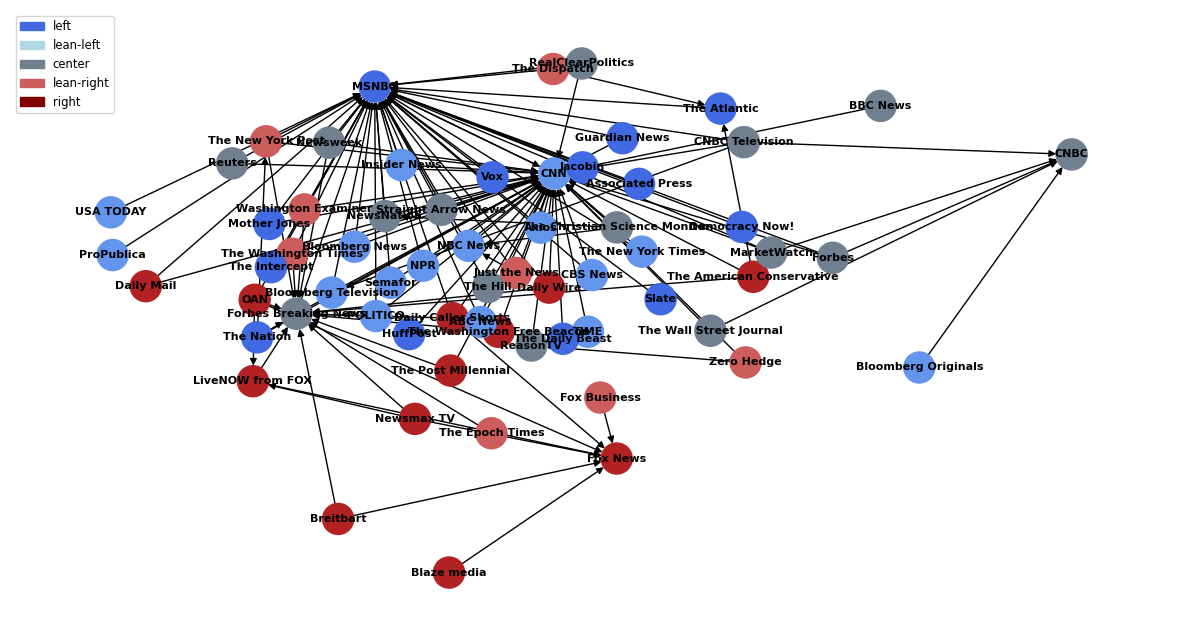

In [19]:
# plot force layout graph
import networkx as nx
graph = nx.DiGraph()
for channel in recommendation_bias:
    graph.add_node(channel, bias=bias_repo.get_bias(channel), name=bias_repo.get_outlet_name_by_id(channel))

edges = {}

for channel in recommendation_bias:
    for video in recommendation_bias[channel]:
        for recommendation in recommendation_bias[channel][video]:
            if recommendation["channel_id"] in graph.nodes:
                if channel not in edges:
                    edges[channel] = {}
                if recommendation["channel_id"] not in edges[channel]:
                    edges[channel][recommendation["channel_id"]] = 0
                edges[channel][recommendation["channel_id"]] += 1

# normalize edge weights so that they sum to 1
for channel in edges:
    total_weight = sum(edges[channel].values())
    for recommendation in edges[channel]:
        edges[channel][recommendation] /= total_weight

# remove edges that are under 0.1
for channel in edges:
    for recommendation in list(edges[channel].keys()):
        if edges[channel][recommendation] < 0.1:
            del edges[channel][recommendation]

for channel in edges:
    for recommendation in edges[channel]:
        if edges[channel][recommendation] > 0 and recommendation != channel:
            graph.add_edge(channel, recommendation, weight=edges[channel][recommendation])


# remove nodes that just have edges to themselves
for node in list(graph.nodes):
    if node in graph.neighbors(node) and len(list(graph.neighbors(node))) == 1:
        graph.remove_node(node)

# reomve nodes with no edges or just outgoing edges
for node in list(graph.nodes):
    if len(list(graph.out_edges(node))) == 0:
        graph.remove_node(node)


layout = nx.spring_layout(graph, seed=42, iterations=1000, weight="weight")
# color according to bias
colors = {
    "left": "royalblue",
    "lean-left": "cornflowerblue",
    "center": "slategray",
    "lean-right": "indianred",
    "right": "firebrick"
}
# draw the graph
plt.figure(figsize=(15, 8))

# legend

# # remove edges where nodes are far apart
for node in list(graph.nodes):
    for neighbor in list(graph.neighbors(node)):
        if abs(layout[node][0] - layout[neighbor][0]) > 0.8 or abs(layout[node][1] - layout[neighbor][1]) > 0.8:
            graph.remove_edge(node, neighbor)

# remove nodes without edges
for node in list(graph.nodes):
    if len(list(graph.out_edges(node))) == 0 and len(list(graph.in_edges(node))) == 0:
        graph.remove_node(node)

from matplotlib.patches import Patch

legend = [
    {'color': 'royalblue', 'label': 'left'},
    {'color': 'lightblue', 'label': 'lean-left'},
    {'color': 'slategray', 'label': 'center'},
    {'color': 'indianred', 'label': 'lean-right'},
    {'color': 'maroon', 'label': 'right'}
]
patches = [Patch(color=entry['color'], label=entry['label']) for entry in legend]
plt.legend(handles=patches, title='', loc='upper left', fontsize='small')

node_colors = [colors[graph.nodes[node]["bias"]] for node in graph.nodes]
nx.draw(graph, with_labels=True, node_color=node_colors, node_size=500, font_size=8, font_weight="bold", arrows=True, labels={node: graph.nodes[node]["name"] for node in graph.nodes}, pos=layout)

The force directed graph shows MSNBC, CNN and Fox News as fix-points of their group. On the right side of the graph most of the channels focus on economics and finance such as Forbes, Bloomberg Originals, MarketWatch or The Wall Street Journal.

In [23]:
# load channels_with_country_code from json file
from src.youTubeApiRepository import YoutubeApiRepository

yt_api = YoutubeApiRepository()

recommended_channels = {}
for channel in recommendation_bias:
    for video in recommendation_bias[channel]:
        for recommendation in recommendation_bias[channel][video]:
            if recommendation['channel_id'] not in recommended_channels:
                recommended_channels[recommendation['channel_id']] = 0
            recommended_channels[recommendation['channel_id']] += 1
try:
    with open('channels_with_country_code.json', 'r') as f:
        channels_with_country_code = json.load(f)
except FileNotFoundError:
    print("channels_with_country_code.json not found, creating new file.")
    countries = {}
    channels_with_country_code = {}
    # get the country code for channel in 50 chunks
    for i in range(0, len(recommended_channels), 50):
        chunk = list(recommended_channels.keys())[i:i+50]
        country_codes = yt_api.get_country_code_by_channel_ids(chunk)
        for channel_id, country_code in country_codes.items():
            channels_with_country_code[channel_id] = {
                'country_code': country_code,
                'recommendations': recommended_channels[channel_id]
            }
    # save channels_with_country_code to json file
    with open('channels_with_country_code.json', 'w') as f:
        json.dump(channels_with_country_code, f)

country_counts = {}
for channel_id, channel_data in channels_with_country_code.items():
    country_code = channel_data['country_code']
    if country_code not in country_counts:
        country_counts[country_code] = 0
    country_counts[country_code] += channel_data['recommendations']
# sort the country counts by number of recommendations
country_counts = dict(sorted(country_counts.items(), key=lambda x: x[1], reverse=True))

In [26]:
import plotly.express as px
import pandas as pd
from iso3166 import countries_by_alpha2
import matplotlib.colors as mcolors


def generate_color_scale(start, end, steps):
    """
    Generate a color scale from start to end color with the given number of steps.
    """
    start_rgb = mcolors.hex2color(start)
    end_rgb = mcolors.hex2color(end)
    return [mcolors.to_hex(color) for color in [
        (
            start_rgb[0] + (end_rgb[0] - start_rgb[0]) * i / (steps - 1),
            start_rgb[1] + (end_rgb[1] - start_rgb[1]) * i / (steps - 1),
            start_rgb[2] + (end_rgb[2] - start_rgb[2]) * i / (steps - 1)
        )
        for i in range(steps)
    ]
    ]
trans_color = 'mediumseagreen'
color_scale1 = generate_color_scale('lightgrey', trans_color, 10)
color_scale2 = generate_color_scale(trans_color, 'maroon', 100)

color_scale = color_scale1 + color_scale2
# Convert to DataFrame
df = pd.DataFrame(list(country_counts.items()), columns=['iso_a2', 'Recommendations'])
# Convert to ISO Alpha-3 for Plotly
def get_iso_a3(code):
    try:
        return countries_by_alpha2[code].alpha3
    except:
        return None

df['iso_a3'] = df['iso_a2'].apply(lambda x: get_iso_a3(x) if x else None)

# Drop rows with no iso_a3 (like None)
df = df.dropna(subset=['iso_a3'])

# Create the map
fig = px.choropleth(
    df,
    locations='iso_a3',
    color='Recommendations',
    color_continuous_scale= color_scale,
    hover_name='iso_a3',
    title='Country Counts Heatmap'
)

# color us in black

fig.update_geos(showcountries=True, projection_type='natural earth')
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})



fig.show()


Most recommendation go to US channels. Followed by english speaking countries such as Canada, UK and Australia. India is also common. Sweden is an outlier likely due to the IP Adress that was used to collect the data.

In [32]:
number_of_recommendations_per_channel = {}
for channel in channel_videos.keys():
    number_of_recommendations_per_channel[channel] = 0
for channel in recommendation_bias:
    for video in recommendation_bias[channel]:
        for recommendation in recommendation_bias[channel][video]:
            if recommendation['channel_id'] in number_of_recommendations_per_channel:
                number_of_recommendations_per_channel[recommendation['channel_id']] += 1

number_of_videos_per_channel = {}
for channel in channel_videos:
    number_of_videos_per_channel[channel] = len(channel_videos[channel])
channel_colors = {}
for channel in number_of_videos_per_channel:
    bias = bias_repo.get_bias(channel)
    if bias == 'right':
        channel_colors[channel] = 'maroon'
    elif bias == 'lean-right':
        channel_colors[channel] = 'indianred'
    elif bias == 'center':
        channel_colors[channel] = 'grey'
    elif bias == 'lean-left':
        channel_colors[channel] = 'cornflowerblue'
    elif bias == 'left':
        channel_colors[channel] = 'royalblue'
    else:
        channel_colors[channel] = 'black'
channel_names = {}
for channel in number_of_videos_per_channel:
    channel_names[channel] = bias_repo.get_outlet_name_by_id(channel)

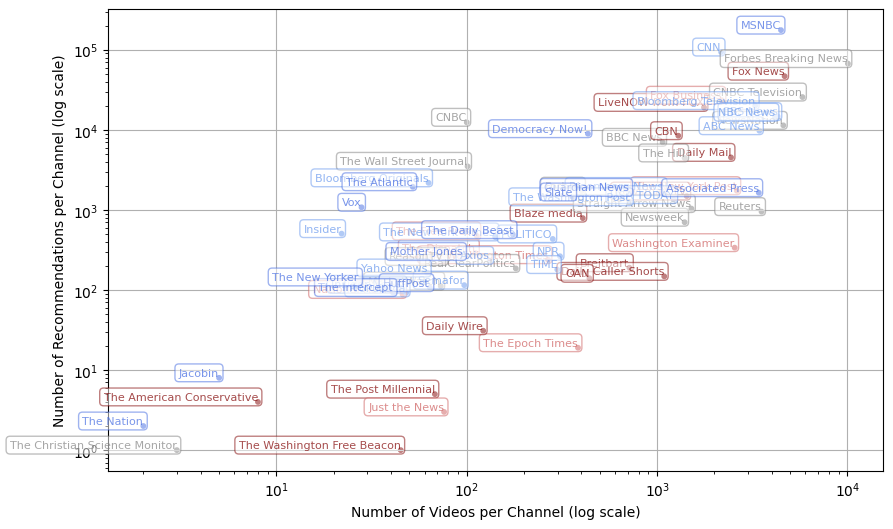

In [33]:
# plot number of recommendations per channel and number of videos per channel as a scatter plot with a log scale
plt.figure(figsize=(10, 6))
plt.scatter(
    list(number_of_videos_per_channel.values()),
    list(number_of_recommendations_per_channel.values()),
    c=[channel_colors[channel] for channel in number_of_videos_per_channel],
    s=10,
)
# add channel names as labels
for i, channel in enumerate(number_of_videos_per_channel):
    plt.annotate(
        channel_names[channel],
        (list(number_of_videos_per_channel.values())[i], list(number_of_recommendations_per_channel.values())[i]),
        fontsize=8,
        alpha=0.7,
        color=channel_colors[channel],
        ha='right',
        va='bottom',
        bbox=dict(boxstyle='round,pad=0.35', edgecolor=channel_colors[channel], facecolor='white', alpha=0.5),
    )
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Videos per Channel (log scale)')
plt.ylabel('Number of Recommendations per Channel (log scale)')
plt.grid()


In [34]:
# load channel_subscriber_count from json file
try:
    with open('channel_subscriber_count.json', 'r') as f:
        channel_subscriber_count = json.load(f)
except FileNotFoundError:
        print("channel_subscriber_count.json not found, creating new file.")
        channel_subscriber_count = {}
        for channel in channel_videos:
            channel_subscriber_count[channel] = 0

        # get the number of subscribers for channels in batch of 50
        for i in range(0, len(channel_videos), 50):
            channels = list(channel_videos.keys())[i:i + 50]
            subscribers_of_the_batch = yt_api.get_number_of_subscribers_by_channel_ids(channels)
            for channel in channels:
                    channel_subscriber_count[channel] = int(subscribers_of_the_batch[channel])

        # save channel subscriber count to json
        with open('channel_subscriber_count.json', 'w') as f:
            json.dump(channel_subscriber_count, f)

Text(0, 0.5, 'Number of Recommendations per Channel (log scale)')

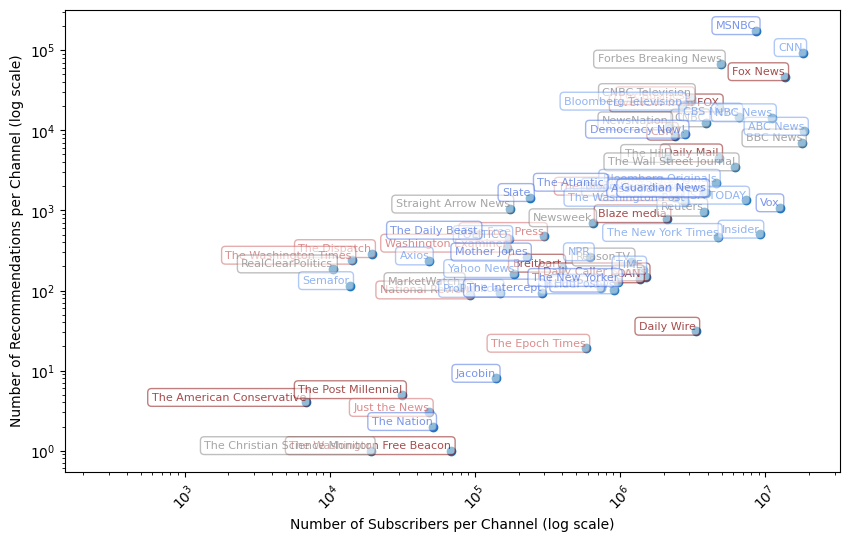

In [35]:
# plot number of recommendations per channel and number of subscribers per channel as a scatter plot with a log scale
plt.figure(figsize=(10, 6))

sub_list = []
num_recom_list = []
for channel in number_of_recommendations_per_channel:
    if channel in channel_subscriber_count:
        sub_list.append(channel_subscriber_count[channel])
        num_recom_list.append(number_of_recommendations_per_channel[channel])

plt.scatter(
    sub_list,
    num_recom_list,
    #c=[channel_colors[channel] for channel in number_of_videos_per_channel],
    #s=10,
)
# add channel names as labels
for i, channel in enumerate(channel_subscriber_count):
    plt.annotate(
        channel_names[channel],
        (list(channel_subscriber_count.values())[i], list(number_of_recommendations_per_channel.values())[i]),
        fontsize=8,
        alpha=0.7,
        color=channel_colors[channel],
        ha='right',
        va='bottom',
        bbox=dict(boxstyle='round,pad=0.35', edgecolor=channel_colors[channel], facecolor='white', alpha=0.5),
    )
plt.xscale('log')
plt.yscale('log')
plt.xticks(rotation=45)
plt.xlabel('Number of Subscribers per Channel (log scale)')
plt.ylabel('Number of Recommendations per Channel (log scale)')

In [ ]:
try:
    # load channel video views from json
    with open('channel_video_views.json', 'r') as f:
        channel_video_views = json.load(f)
    # load total channel views from json
    with open('total_channel_views.json', 'r') as f:
        total_channel_views = json.load(f)
except FileNotFoundError:
    print("channel_video_views.json or total_channel_views.json not found, creating new file.")
    channel_video_views = {}
    total_channel_views = {}
    for channel in channel_videos:
        # in batches of 50
        for i in range(0, len(channel_videos[channel]), 50):
            video_ids = [vid['snippet']['resourceId']['videoId'] for vid in channel_videos[channel][i:i + 50]]
            video_views_of_the_batch = yt_api.get_number_of_video_views_by_video_ids(video_ids)
            for video in video_ids:
                if video in video_views_of_the_batch:
                    if channel not in channel_video_views:
                        channel_video_views[channel] = {}
                    channel_video_views[channel][video] = int(video_views_of_the_batch[video])
                    if channel not in total_channel_views:
                        total_channel_views[channel] = 0
                    total_channel_views[channel] += int(video_views_of_the_batch[video])
    # save channel video views to json
    with open('channel_video_views.json', 'w') as f:
        json.dump(channel_video_views, f)
    # save total channel views to json
    with open('total_channel_views.json', 'w') as f:
        json.dump(total_channel_views, f)


channel_video_views.json or total_channel_views.json not found, creating new file.


In [41]:
try:
    # load channel video likes from json
    with open('channel_video_likes.json', 'r') as f:
        channel_video_likes = json.load(f)
    # load channel video comments from json
    with open('channel_video_comments.json', 'r') as f:
        channel_video_comments = json.load(f)
    # load total channel likes from json
    with open('total_channel_likes.json', 'r') as f:
        total_channel_likes = json.load(f)
    # load total channel comments from json
    with open('total_channel_comments.json', 'r') as f:
        total_channel_comments = json.load(f)
except FileNotFoundError:
    channel_video_likes = {}
    channel_video_comments = {}
    total_channel_likes = {}
    total_channel_comments = {}

    for channel in channel_videos:
        # in batches of 50
        for i in range(0, len(channel_videos[channel]), 50):
            video_ids = [vid['snippet']['resourceId']['videoId'] for vid in channel_videos[channel][i:i + 50]]
            video_likes_and_comments_of_the_batch = yt_api.get_number_of_likes_and_comments_by_video_ids(video_ids)
            for video in video_ids:
                if video in video_likes_and_comments_of_the_batch:
                    if channel not in channel_video_likes:
                        channel_video_likes[channel] = {}
                    if channel not in channel_video_comments:
                        channel_video_comments[channel] = {}
                    channel_video_likes[channel][video] = int(video_likes_and_comments_of_the_batch[video]['likes'])
                    channel_video_comments[channel][video] = int(video_likes_and_comments_of_the_batch[video]['comments'])
                    if channel not in total_channel_likes:
                        total_channel_likes[channel] = 0
                    if channel not in total_channel_comments:
                        total_channel_comments[channel] = 0
                    total_channel_likes[channel] += int(video_likes_and_comments_of_the_batch[video]['likes'])
                    total_channel_comments[channel] += int(video_likes_and_comments_of_the_batch[video]['comments'])

    # save channel video likes to json
    with open('channel_video_likes.json', 'w') as f:
        json.dump(channel_video_likes, f)
    # save channel video comments to json
    with open('channel_video_comments.json', 'w') as f:
        json.dump(channel_video_comments, f)
    # save total channel likes to json
    with open('total_channel_likes.json', 'w') as f:
        json.dump(total_channel_likes, f)
    # save total channel comments to json
    with open('total_channel_comments.json', 'w') as f:
        json.dump(total_channel_comments, f)

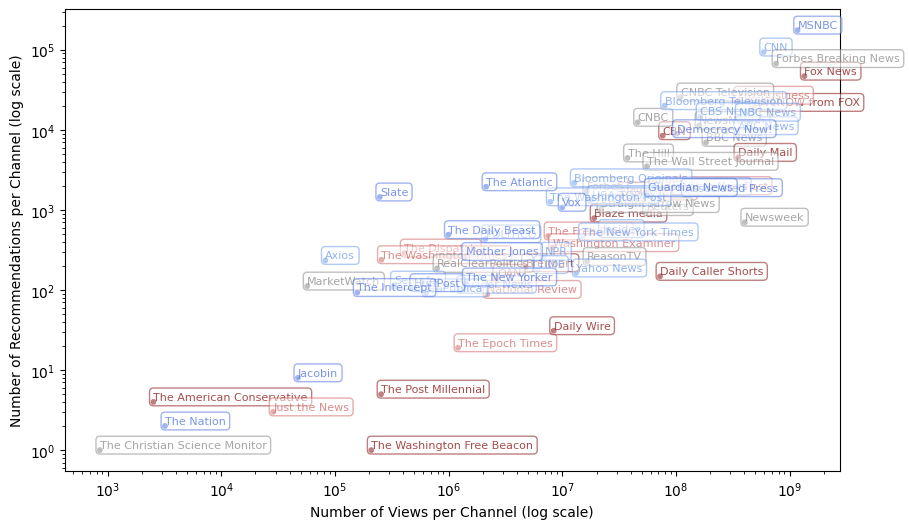

In [45]:
# plot number of recommendations per channel and number of views per channel as a scatter plot with a log scale
plt.figure(figsize=(10, 6))
label_list = []
recom_list = []
view_list = []
c_list = []

for channel in number_of_recommendations_per_channel:
    if channel in total_channel_views:
        recom_list.append(number_of_recommendations_per_channel[channel])
        view_list.append(total_channel_views[channel])
        c_list.append(channel_colors[channel])
        label_list.append(channel_names[channel])
plt.scatter(
    view_list,
    recom_list,
    c=c_list,
    s=10,
)

# add channel names as labels
for i, label in enumerate(label_list):
    plt.annotate(
        label,
        (view_list[i], recom_list[i]),
        fontsize=8,
        alpha=0.7,
        color=c_list[i],
        ha='left',
        va='bottom',
        bbox=dict(boxstyle='round,pad=0.35', edgecolor=c_list[i], facecolor='white', alpha=0.5),
    )
plt.xscale('log')
plt.yscale('log')

plt.ylabel('Number of Recommendations per Channel (log scale)')
plt.xlabel('Number of Views per Channel (log scale)')
plt.show()


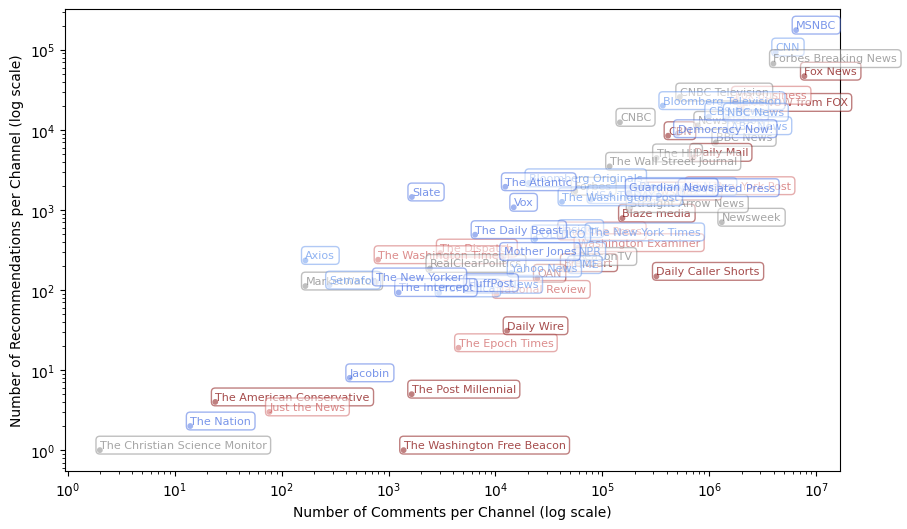

In [43]:
# plot number of recommendations per channel and number of comments per channel as a scatter plot with a log scale
plt.figure(figsize=(10, 6))
label_list = []
recom_list_comments = []
comments_list = []
c_list_comments = []
for channel in number_of_recommendations_per_channel:
    if channel in total_channel_comments:
        recom_list_comments.append(number_of_recommendations_per_channel[channel])
        comments_list.append(total_channel_comments[channel])
        c_list_comments.append(channel_colors[channel])
        label_list.append(channel_names[channel])
plt.scatter(
    comments_list,
    recom_list_comments,
    c=c_list_comments,
    s=10,
)
# add channel names as labels
for i, label in enumerate(label_list):
    plt.annotate(
        label,
        (comments_list[i], recom_list_comments[i]),
        fontsize=8,
        alpha=0.7,
        color=c_list_comments[i],
        ha='left',
        va='bottom',
        bbox=dict(boxstyle='round,pad=0.35', edgecolor=c_list_comments[i], facecolor='white', alpha=0.5),
    )
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Number of Recommendations per Channel (log scale)')
plt.xlabel('Number of Comments per Channel (log scale)')
plt.show()

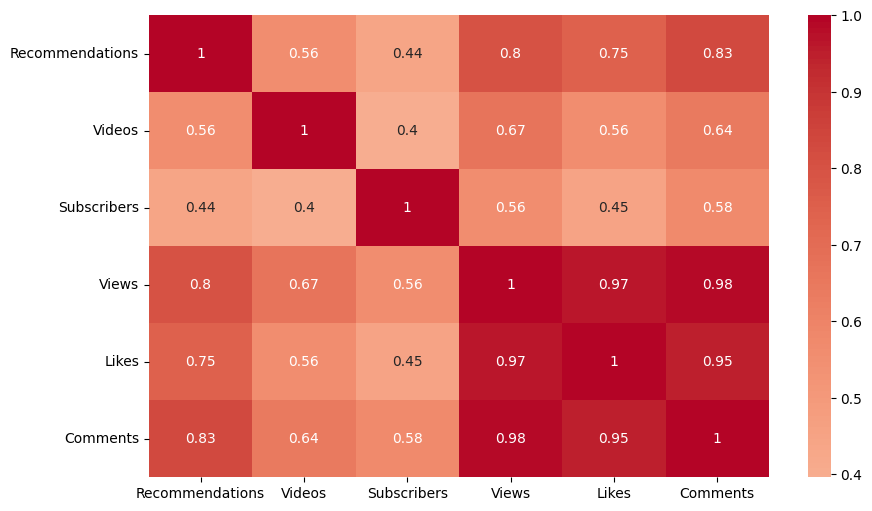

In [46]:
# check which factors are most correlated with the number of recommendations
# correlation with number of videos
import numpy as np

def calculate_correlation(x, y):
    x = np.array(x)
    y = np.array(y)
    if len(x) != len(y):
        raise ValueError("x and y must have the same length")
    if len(x) == 0:
        return 0
    if len(x) == 1:
        return 1
    return np.corrcoef(x, y)[0, 1]

# plot correlation matrix
import seaborn as sns
import pandas as pd


channel_attributes = {}

for channel in total_channel_comments:
    channel_attributes[channel] = {
        'Recommendations': number_of_recommendations_per_channel[channel],
        'Videos': number_of_videos_per_channel[channel],
        'Subscribers': channel_subscriber_count[channel],
        'Views': total_channel_views[channel],
        'Likes': total_channel_likes[channel],
        'Comments': total_channel_comments[channel],
    }

channel_attributes_df = pd.DataFrame.from_dict(channel_attributes, orient='index')

# correlation matrix
correlation_matrix = channel_attributes_df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.show()

The strongest correlation to recommendation are interaction metrics such as comments, views and likes.

**The diagrams regarding the alternative/extremist channels are not in the repository, because the dataset is not public.**